In [2]:
# get data 
# y = lineup +/-
# X = summed box score data season averages for each offensive / defensive player

# go through each season
    # go through each lineup
        # add +/- to y
        # get season averages for each player
        # add offensive and defensive sums to X


## Calculate Box score Plus Minus
regress box score statistics against +/- for each possession

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from nba_utils import seasons
from nba import NbaTracker

nbaTracker = NbaTracker()

nbaTracker.load_seasons()


Loaded  2000-01
Loaded  2001-02
Loaded  2002-03
Loaded  2003-04
Loaded  2004-05
Loaded  2005-06
Loaded  2006-07
Loaded  2007-08
Loaded  2008-09
Loaded  2009-10
Loaded  2010-11
Loaded  2011-12
Loaded  2012-13
Loaded  2013-14
Loaded  2014-15
Loaded  2015-16
Loaded  2016-17
Loaded  2017-18
Loaded  2018-19
Loaded  2019-20
Loaded  2020-21


In [2]:
for name, season in nbaTracker.seasons.items():
    print(name, hasattr(season, 'games'))

2000-01 True
2001-02 True
2002-03 True
2003-04 True
2004-05 True
2005-06 True
2006-07 True
2007-08 True
2008-09 True
2009-10 True
2010-11 True
2011-12 True
2012-13 True
2013-14 False
2014-15 True
2015-16 True
2016-17 True
2017-18 True
2018-19 True
2019-20 True
2020-21 True


In [3]:
import numpy as np
y = np.zeros((0))  # (n_samples)
diff_la = np.zeros((0))
X = []  # (n_samples, 2 * 18 stats)
offense = np.zeros((0, 5, 18), dtype=np.float32)  # (n_samples, 5 players, 18 stats)
defense = np.zeros((0, 5, 18), dtype=np.float32)  # (n_samples, 5 players, 18 stats)
sample_weights = []  # (n_samples)
for season in nbaTracker.seasons.values():
    season.build_player_seasons()
    
    if not hasattr(season, 'lineups'):
        continue
    season_offense = []
    season_defense = []
    season_ppp = []
    total_points = 0
    total_possessions = 0
    for lineup, stats in season.lineups.items():
        
        season_ppp.append(stats.shot_points / stats.possessions)
        sample_weights.append(stats.possessions)
        total_points += stats.shot_points
        total_possessions += stats.possessions

        offense_stats = [0] * 18
        offense_player_stats = []
        for offensive_player in lineup.off_players.split('-'):
            pid = int(offensive_player)
            # get per minute stats
            player_stats = season.player_seasons[pid].get_stats()
            for i, stat in enumerate(player_stats):
                offense_stats[i] += stat
            offense_player_stats.append(player_stats)
            
        defense_stats = [0] * 18
        defense_player_stats = []
        for defensive_player in lineup.def_players.split('-'):
            pid = int(defensive_player)
            # get per minute stats
            player_stats = season.player_seasons[pid].get_stats()
            for i, stat in enumerate(player_stats):
                defense_stats[i] += stat
            defense_player_stats.append(player_stats)
            
                
        X.append(offense_stats+defense_stats)
        season_offense.append(offense_player_stats)
        season_defense.append(defense_player_stats)

    season_offense = np.array(season_offense, dtype=np.float32)
    offense = np.concatenate((offense, season_offense), axis=0)
    season_defense = np.array(season_defense, dtype=np.float32)
    defense = np.concatenate((defense, season_defense), axis=0)
    season_ppp = np.array(season_ppp, dtype=np.float32)
    y = np.concatenate((y, season_ppp))
    diff_la = np.concatenate((diff_la, season_ppp - total_points / total_possessions))
    print("loaded", season.name)
X = np.array(X, dtype=np.float32)
# y = np.array(y, dtype=np.float32)
# offense = np.array(offense, dtype=np.float32)
# defense = np.array(defense, dtype=np.float32)
sample_weights = np.array(sample_weights, dtype=np.float32)
    


loaded 2000-01
loaded 2001-02
loaded 2002-03
loaded 2003-04
loaded 2004-05
loaded 2005-06
loaded 2006-07
loaded 2007-08
loaded 2008-09
loaded 2009-10
loaded 2010-11
loaded 2011-12
loaded 2012-13
loaded 2014-15
loaded 2015-16
loaded 2016-17
loaded 2017-18
loaded 2018-19
loaded 2019-20
loaded 2020-21


In [4]:
diff_la = np.array(diff_la, dtype=np.float32)


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, diff_la_train, diff_la_test, offense_train, offense_test, defense_train, defense_test, sample_weights_train, sample_weights_test = train_test_split(
    X, y, diff_la, offense, defense, sample_weights, test_size=0.2, random_state=424)
X_train, X_val, y_train, y_val, diff_la_train, diff_la_val, offense_train, offense_val, defense_train, defense_val, sample_weights_train, sample_weights_val = train_test_split(
    X_train, y_train, diff_la_train, offense_train, defense_train, sample_weights_train, test_size=0.2, random_state=424)


In [6]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices(((offense_train, defense_train), diff_la_train, sample_weights_train))
train_dataset = train_dataset.shuffle(5000).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices(
    ((offense_val, defense_val), diff_la_val, sample_weights_val))
val_dataset = val_dataset.batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices(
    ((offense_test, defense_test), diff_la_test, sample_weights_test))
test_dataset = test_dataset.batch(32)


(array([     0., 177442., 170986., 127523.,  90606.,  55110.,  36275.,
         20141.,  14415.,   8509.,   7203.,   4488.,   4044.,   2753.,
          2665.,   1951.,   1913.,   1711.,   3674.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <BarContainer object of 19 artists>)

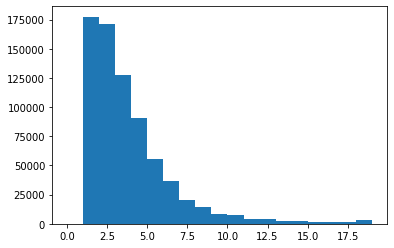

In [28]:
import matplotlib.pyplot as plt 
plt.hist(sample_weights_train,range(20))


In [29]:
train_dataset = train_dataset.prefetch(1)
val_dataset = val_dataset.prefetch(1)
# test_dataset

In [12]:
flat_offense_train = offense_train.reshape(len(offense_train), -1)
flat_offense_test = offense_test.reshape(len(offense_test), -1)
flat_defense_train = defense_train.reshape(len(defense_train), -1)
flat_defense_test = defense_test.reshape(len(defense_test), -1)
flat_players_train = np.c_[flat_offense_train, flat_defense_train]
flat_players_test = np.c_[flat_offense_test, flat_defense_test]

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor

linear = make_pipeline(StandardScaler(), BayesianRidge())
randfor = make_pipeline(StandardScaler(), RandomForestRegressor())
randfor2 = make_pipeline(StandardScaler(), RandomForestRegressor())


In [14]:
linear.fit(X_train, y_train,
           bayesianridge__sample_weight=sample_weights_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('bayesianridge', BayesianRidge())])

In [ ]:
# randfor.fit(X_train, y_train,
#             randomforestregressor__sample_weight=sample_weights_train)

In [ ]:
# randfor2.fit(flat_players_train, y_train,
#              randomforestregressor__sample_weight=sample_weights_train)

In [16]:
linear.predict(X_train[:10]) 
#, randfor.predict(
    # X_train[:10]), randfor2.predict(flat_players_train[:10])


array([1.01359123, 0.9219182 , 1.18557669, 0.93977863, 1.09432922,
       1.10774931, 0.96800299, 1.08574112, 1.0452237 , 1.07218523])

In [17]:
y_train[:10]

array([0.       , 2.       , 0.75     , 3.       , 1.       , 1.6666666,
       3.       , 0.       , 2.5      , 0.       ], dtype=float32)

In [18]:
linear.score(X_test, y_test,
               sample_weight=sample_weights_test)


0.016713688449819686

In [19]:
def contribution(test):
    return linear.predict([test])[0] - linear['bayesianridge'].intercept_

zero = linear['standardscaler'].inverse_transform([[0]*36])[0]
def calc_bpm(stats):
    offense = zero * ([.8]*18 + [1]*18 )+ np.array(stats + [0]*18)
    defense = zero * ([1]*18 + [.8]*18) + np.array([0]*18 + stats)
    return contribution(offense) - contribution(defense)

In [20]:
zero


array([-0.01560948,  2.06718911,  1.26156675,  2.41600036,  0.6122241 ,
        0.44153018,  1.41189734,  0.15727975,  0.48911498,  3.77176974,
        0.37090166,  0.22544958,  0.64556918,  0.45413137,  0.09940359,
        0.15731821,  0.28443929,  0.43836341, -0.01685203,  2.06437306,
        1.26079122,  2.41602905,  0.61187763,  0.44016084,  1.40975134,
        0.15671272,  0.48883948,  3.76936371,  0.37047966,  0.22591261,
        0.64581631,  0.45347875,  0.09961916,  0.15738121,  0.28431411,
        0.43883262])

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class CombineAveBpmLayer(Layer):
    def call(self, X):
        off_ave, def_ave = X
        return tf.multiply(off_ave, 5.) + tf.multiply(def_ave, -5.)
    def compute_output_shape(self, batch_input_shape):
        return (batch_input_shape[1], 1, 1)


In [8]:

from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Input, AvgPool1D, Normalization

off_input = Input(shape=offense.shape[1:])
off_norm = Normalization()(off_input)
off_conv1 = Conv1D(64, 1, activation='relu', kernel_initializer='he_normal')(off_norm)
off_conv2 = Conv1D(64, 1, activation='relu',
                   kernel_initializer='he_normal')(off_conv1)
off_bpm = Conv1D(1, 1)(off_conv2) # (n, 5, 1)
off_ave = AvgPool1D(pool_size=5)(off_bpm)  # (n, 1, 1)

def_input = Input(shape=defense.shape[1:])
def_norm = Normalization()(def_input)
def_conv1 = Conv1D(64, 1, activation='relu', kernel_initializer='he_normal')(def_norm)
def_conv2 = Conv1D(64, 1, activation='relu',
                   kernel_initializer='he_normal')(def_conv1)
def_bpm = Conv1D(1, 1)(def_conv2)  # (n, 5, 1)
def_ave = AvgPool1D(pool_size=5)(def_bpm)  # (n, 1, 1)

output = CombineAveBpmLayer()([off_ave, def_ave])
output = Flatten()(output)

# d1 = Dense(128, activation='relu')(flat)
# output = Dense(30)(d1)


In [9]:
off_bpm_model = keras.models.Model(inputs=[off_input], outputs=[off_bpm])
def_bpm_model = keras.models.Model(inputs=[def_input], outputs=[def_bpm])


In [34]:
off_bpm_model(offense[0][1])[0][0][0].numpy()
# offense[0][1].shape, np.array(ps.get_stats()).shape


-0.0011868546

In [10]:


model = keras.models.Model(inputs=[off_input, def_input], outputs=[output])
model.compile(optimizer='adam', loss=keras.losses.MeanAbsoluteError())


In [35]:
model([offense[:10], defense[:10]])
# sample_weights[:20]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[-0.06920142],
       [-0.0295538 ],
       [-0.08529197],
       [-0.01268402],
       [-0.08529197],
       [-0.01268402],
       [-0.06769754],
       [-0.00713636],
       [-0.05187774],
       [-0.03682207]], dtype=float32)>

In [11]:
import os
import time
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [31]:
run_logdir = get_run_logdir()
run_logdir


In [43]:
!$$Env:Path

The filename, directory name, or volume label syntax is incorrect.


In [33]:
tensorboard_cb = keras.callbacks.TensorBoard(
    run_logdir, profile_batch='10, 15')
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=5, restore_best_weights=True)
history = model.fit(train_dataset, epochs=2, callbacks=[
                    tensorboard_cb, early_stopping_cb], validation_data=val_dataset)


Epoch 1/2
23366/23366 [==============================] - 482s 21ms/step - loss: 1.6840 - val_loss: 1.6833
Epoch 2/2
23366/23366 [==============================] - 450s 19ms/step - loss: 1.6839 - val_loss: 1.6858


In [13]:
model.evaluate(test_dataset)


7302/7302 [==============================] - 51s 7ms/step - loss: 1.6921


1.692126989364624

In [14]:
all_player_seasons = []
for season in nbaTracker.seasons.values():
    for ps in season.player_seasons.values():
        ps.off_bpm = off_bpm_model(np.array(ps.get_stats()))[0][0][0].numpy()
        ps.def_bpm = def_bpm_model(np.array(ps.get_stats()))[0][0][0].numpy()
        ps.bpm = ps.off_bpm + ps.def_bpm
        ps.season = season.name
        all_player_seasons.append(ps)

In [38]:
all_player_seasons[12].off_bpm

-0.023883045

In [15]:
for ps in sorted(all_player_seasons, key=lambda ps: ps.bpm * ps.game_time / 60, reverse=True):
    if ps.game_time > 60*200:
        total = ps.bpm * ps.game_time / 60
        print(ps.season, ps.name, total, ps.bpm)

2015-16 Stephen Curry 170.24081295728683 0.063050985
2016-17 Stephen Curry 157.22628706072769 0.059591904
2014-15 Stephen Curry 146.91763941993315 0.056220636
2008-09 LeBron James 145.81394307253262 0.04774784
2012-13 Kevin Durant 136.03280399342378 0.0436161
2009-10 LeBron James 133.5647149644792 0.04503067
2013-14 Kevin Durant 125.96640206500888 0.04035186
2008-09 Kobe Bryant 125.9294786942502 0.042534642
2007-08 Kobe Bryant 125.25428937934339 0.039236583
2015-16 Draymond Green 125.23830279707909 0.044600535
2005-06 Chauncey Billups 121.59536249153317 0.041577224
2012-13 LeBron James 121.57752683497965 0.042257704
2017-18 James Harden 121.4574944232901 0.04761514
2015-16 Klay Thompson 119.36504637325804 0.044771686
2018-19 Stephen Curry 118.68354260468234 0.05091056
2007-08 Paul Pierce 118.66015216087301 0.041292246
2014-15 Chris Paul 118.56194714605809 0.0414944
2018-19 Kevin Durant 118.09039470578233 0.04371236
2016-17 James Harden 116.72181375523408 0.039610803
2015-16 Russell Wes

In [16]:
from pbpstats.client import Client
from nba_utils import seconds_from_time

game_settings = {
    "dir": "C:/Users/bhalb/nbaproject/response_data",
    "Boxscore": {"source": "file", "data_provider": "stats_nba"},
}
season_settings = {
    "dir": "C:/Users/bhalb/nbaproject/response_data",
    "Games": {"source": "file", "data_provider": "stats_nba"},
}
game_client = Client(game_settings)
season_client = Client(season_settings)
is_home_wins = []
home_pms = []
pm_diffs = []
for season in nbaTracker.seasons.values():
    schedule = season_client.Season("nba", season.name, "Regular Season")
    for game_dict in schedule.games.final_games:
        game_id = game_dict['game_id']
        game = game_client.Game(game_id)
        home_team = game.boxscore.team_items[0]
        home_team_id = home_team['team_id']
        home_pm = home_team['plus_minus']
        home_pms.append(home_pm)
        if home_pm > 0:
            is_win = True
        else:
            is_win = False
        is_home_wins.append(is_win)
        pm_diff = 0
        for player_dict in filter(lambda p: p['team_id'] == home_team_id, game.boxscore.player_items):
            if not player_dict['min'] or player_dict['min'] == '':
                continue
            player_id = player_dict['player_id']
            bpm = season.player_seasons[player_id].bpm
            seconds = seconds_from_time(player_dict['min'])
            pm_diff += bpm * seconds / 60
        away_team = game.boxscore.team_items[1]
        away_team_id = away_team['team_id']
        for player_dict in filter(lambda p: p['team_id'] == away_team_id, game.boxscore.player_items):
            if not player_dict['min'] or player_dict['min'] == '':
                continue
            player_id = player_dict['player_id']
            bpm = season.player_seasons[player_id].bpm
            seconds = seconds_from_time(player_dict['min'])
            pm_diff -= bpm * seconds / 60
        pm_diffs.append([pm_diff])
    print("loaded",season.name)


In [17]:
home_pms[:10], pm_diffs[:10]


([29.0, -4.0, -11.0, 24.0, -9.0, 19.0, -4.0, 8.0, 13.0, 13.0],
 [[0.41798802778745675],
  [-0.4172150964421842],
  [-1.6892555680281172],
  [5.069053674931638],
  [0.6034111746160006],
  [8.087147286526548],
  [-0.2449617351482929],
  [-0.2216717042804997],
  [3.3721114221805086],
  [4.217401986607971]])

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression

logreg = make_pipeline(StandardScaler(), LogisticRegression())
linreg = make_pipeline(StandardScaler(), LinearRegression())


In [20]:
X_train, X_test, y_train, y_test, y2_train, y2_test = train_test_split(
    pm_diffs, is_home_wins, home_pms, test_size=0.2, random_state=424)


In [21]:
logreg.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [22]:
logreg.predict_proba(pm_diffs[:10])


array([[0.47032895, 0.52967105],
       [0.53262786, 0.46737214],
       [0.62497651, 0.37502349],
       [0.18118312, 0.81881688],
       [0.45655486, 0.54344514],
       [0.08241163, 0.91758837],
       [0.51979855, 0.48020145],
       [0.51806154, 0.48193846],
       [0.26866969, 0.73133031],
       [0.2220228 , 0.7779772 ]])

In [23]:
logreg.score(X_test, y_test)

0.6767576180043816

In [24]:
linreg.fit(X_train, y2_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [25]:
linreg.predict(pm_diffs[:10])

array([ 0.77865842, -0.79818179, -3.19975873,  9.55974067,  1.12873215,
       15.25781725, -0.47297224, -0.42900132,  6.35596102,  7.95184603])

In [26]:
linreg.score(X_test, y2_test)


0.2331941721047861